# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# CNN Multilabeling through AlexNet
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

El objetivo de este notebook es realizar predicciones multilabel sobre patrones geométricos mediante AlexNet.

## Imports

In [28]:
root_dir = '../'

In [36]:
import os
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import math
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
from matplotlib import pyplot as plt


from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter


## Configuración de dispositivo

In [37]:
# 0 es 3090, 1 y 2 son 2080
CUDA_ID = 0

device = torch.device(f'cuda:{CUDA_ID}' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {torch.cuda.get_device_name(device)}")

Usando device: NVIDIA GeForce GTX 1060


## Configuración del experimento

In [38]:
# Flags para los datos sintéticos
# Cada flag está asociada a una o más funciones de data augmentation.
# Los datos deben existir previamente 
# (se generan a partir del notebook split and augmentation)
DS_FLAGS = ['ref', 'rot', 'rain', 'elastic', 'blur']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'gausblur': [gausblur]
              # 'msblur': [msblur]
              # 'mtnblur': [mtnblur]
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
            
# Las flags crop, randaug, elastic y gausblur 
# se pueden aplicar más de una vez c/u. 
# (si no están en DS_FLAGS, serán ignoradas).
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
GAUSBLUR_TIMES = 1

# Usar pesos en el entrenamiento
use_pos_weights = True
pos_weights_factor = 1

# Cantidad de etiquetas en estudio y batch_size
NUM_LABELS = 107
BATCH_SIZE = 124

# Threshold de asignación en entrenamiento, validación y test
TH_TRAIN = 0.75
TH_VAL = 0.75
TH_TEST = 0.75

# Guardar  resultados?
SAVE = False

# Cantidad de folds
K = 4

In [39]:
# Esta celda construye la variable data_flags, que lee DS_FLAGS de 
# la celda anterior y mapea su contenido a distintas rutas de 
# patrones, etiquetas y outputs
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
         'gausblur': GAUSBLUR_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic', 'gausblur']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

# Revisión de los folds y creación de diccionario con paths
Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    patterns_dir = os.path.join(root_dir, 'patterns', data_flags, str(i))
    labels_dir = os.path.join(root_dir, 'labels', data_flags, str(i))

    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
        
    exp_name = f"{NUM_LABELS}L"
    weights_str = str(pos_weights_factor)
    weights_str = weights_str.replace('.','_')
    exp_name += f'_weighted_{weights_str}' if use_pos_weights else ''
    print(f"Nombre del experimento: {exp_name}")
     
    output_dir = os.path.join(root_dir, "outputs", "alexnet",'testlocochon', data_flags, exp_name, str(i))
    model_dir = os.path.join(root_dir, "models", "alexnet", data_flags, str(i))
    model_path = os.path.join(model_dir, exp_name + '.pth')

    
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'output_dir': output_dir,
        'model_path': model_path
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("")
    

    if SAVE:
        os.makedirs(output_dir, exist_ok = True)
        os.makedirs(model_dir, exist_ok = True)
        print(f"Los resultados se guardarán en: {output_dir}")
        print(f"Los modelos se guardarán en: {model_dir}")

Fold  0
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns\blur_rain_ref_rot_elastic1\0
--Labels set encontrado en ../labels\blur_rain_ref_rot_elastic1\0

Fold  1
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns\blur_rain_ref_rot_elastic1\1
--Labels set encontrado en ../labels\blur_rain_ref_rot_elastic1\1

Fold  2
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns\blur_rain_ref_rot_elastic1\2
--Labels set encontrado en ../labels\blur_rain_ref_rot_elastic1\2

Fold  3
Nombre del experimento: 107L_weighted_1
--Pattern set encontrado en ../patterns\blur_rain_ref_rot_elastic1\3
--Labels set encontrado en ../labels\blur_rain_ref_rot_elastic1\3



## Funciones auxiliares

In [40]:
def make_positive_weights(labels, n_samples, factor=1):     
    total = n_samples #labels.values.sum()
    weights = [0.] * len(labels)
    for i, label in enumerate(labels):
      weights[i] = total/(factor * labels[i])
    return weights

# images_dir=os.path.join(root_dir, 'patterns', data_flags, 'train'),
# labels_file=os.path.join(root_dir, 'labels', data_flags, 'augmented_train_df.json'),
class KunischDataset(torch.utils.data.Dataset):

  def __init__(self, images_dir, labels_file, transform, top_labels):
    self.pruner = KunischPruner(len(top_labels))
    self.pruner.set_top_labels(top_labels)
    labels = pd.read_json(labels_file, orient='index')
    self.labels_frame = self.pruner.filter_df(labels)
    self.num_labels = len(top_labels)
    self.images_dir = images_dir
    self.labels_file = labels_file
    self.transform = transform
    self.flags = data_flags
    self.top_labels = top_labels

  def __len__(self):
    return len(self.labels_frame)

  def __getitem__(self, idx):
    img_id = self.labels_frame.iloc[idx].name + '.png'
    img_name = None
    for chapter in os.listdir(self.images_dir):
      if img_id in os.listdir(os.path.join(self.images_dir, chapter)):
        img_name = os.path.join(self.images_dir, chapter, img_id)
        break
    if img_name is None:
      raise Exception(f'No se encontró la imagen para {img_id}')
    image = Image.open(img_name)
    image = image.convert('RGB')
    image = self.transform(image)
    labels = self.labels_frame.iloc[idx].values
    labels = np.array(labels)
    labels = torch.from_numpy(labels.astype('int'))
    #print(img_id, img_name, self.labels_frame.iloc[idx], self.labels_frame.iloc[idx].values, labels)
    sample = {'image': image, 'labels': labels, 'paths': img_name}
    return sample


# Define the function for training, validation, and test
def alex_train(epoch, num_epochs, train_losses, learning_rate, w):
  alex_net.train()
  train_loss = 0
  TN = 0
  TP = 0
  FP = 0
  FN = 0
  preds_total = np.empty((1, NUM_LABELS), dtype=int)
  labels_total = np.empty((1, NUM_LABELS), dtype=int)
    
  for i, sample_batched in enumerate(kunischTrainLoader, 1):
      inputs = sample_batched['image'].to(device)
      labels = sample_batched['labels'].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = alex_net(inputs)
      loss = criterion(outputs.float(), labels.float())
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      pred = (torch.sigmoid(outputs).data > TH_TRAIN).int()
      # print(pred)
      labels = labels.int()
      # print(labels)
      preds_total = np.concatenate((preds_total, pred.cpu()), axis=0)
      labels_total = np.concatenate((labels_total, labels.cpu()), axis=0)
    
      TP += ((pred == 1) & (labels == 1)).float().sum()  # True Positive Count
      TN += ((pred == 0) & (labels == 0)).float().sum()  # True Negative Count
      FP += ((pred == 1) & (labels == 0)).float().sum()  # False Positive Count
      FN += ((pred == 0) & (labels == 1)).float().sum()  # False Negative Count
      #print('TP: {}\t TN: {}\t FP: {}\t FN: {}\n'.format(TP, TN, FP, FN))
  

  TP = TP.cpu().numpy()
  TN = TN.cpu().numpy()
  FP = FP.cpu().numpy()
  FN = FN.cpu().numpy()

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f2_score = (1+2**2) * (precision * recall) / ((2**2*precision) + recall)
  train_loss = train_loss / len(kunischTrainLoader.dataset) * BATCH_SIZE
  train_losses.append([epoch, learning_rate, w, train_loss, TP, TN, FP, FN, accuracy, precision, recall, f1_score,
                      f2_score])

  # print statistics
  print('Train Trial [{}/{}], LR: {:.4g}, W: {}, Avg Loss: {:.4f}, Accuracy: {:.4f}, F1 score: {:.4f}, F2 score: {:.4f}'
        .format(epoch, num_epochs, optimizer.param_groups[0]['lr'], w, train_loss, accuracy, f1_score, f2_score))
  return f2_score


def alex_valid(epoch, num_epochs, valid_losses, learning_rate, w):
  # Have our model in evaluation mode
  alex_net.eval()
  # Set losses and Correct labels to zero
  valid_loss = 0
  TN = 0
  TP = 0
  FP = 0
  FN = 0
  preds_total = np.empty((1, NUM_LABELS), dtype=int)
  labels_total = np.empty((1, NUM_LABELS), dtype=int)
  with torch.no_grad():
      for i, sample_batched in enumerate(kunischValidationLoader, 1):
          inputs = sample_batched['image'].to(device)
          labels = sample_batched['labels'].to(device)
          outputs = alex_net(inputs)
          loss = criterion(outputs.float(), labels.float())
          valid_loss += loss.item()
          pred = (torch.sigmoid(outputs).data > TH_VAL).int()
          labels = labels.int()
          preds_total = np.concatenate((preds_total, pred.cpu()), axis=0)
          labels_total = np.concatenate((labels_total, labels.cpu()), axis=0)
        
          TP += ((pred == 1) & (labels == 1)).float().sum()  # True Positive Count
          TN += ((pred == 0) & (labels == 0)).float().sum()  # True Negative Count
          FP += ((pred == 1) & (labels == 0)).float().sum()  # False Positive Count
          FN += ((pred == 0) & (labels == 1)).float().sum()  # False Negative Count
          # print('TP: {}\t TN: {}\t FP: {}\t FN: {}\n'.format(TP,TN,FP,FN) )

      TP = TP.cpu().numpy()
      TN = TN.cpu().numpy()
      FP = FP.cpu().numpy()
      FN = FN.cpu().numpy()
      accuracy = (TP + TN) / (TP + TN + FP + FN)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1_score = 2 * (precision * recall) / (precision + recall)
      f2_score = (1+2**2) * (precision * recall) / ((2**2*precision) + recall)
      
      scheduler.step(f2_score)

      valid_loss = valid_loss / len(kunischValidationLoader.dataset) * BATCH_SIZE  # 1024 is the batch size
      valid_losses.append(
          [epoch, learning_rate, w, valid_loss, TP, TN, FP, FN, accuracy, precision, recall, f1_score,
          f2_score])
      # print statistics
      print('Valid Trial [{}/{}], LR: {}, W: {}, Avg Loss: {:.4f}, Accuracy: {:.4f}, F1 score: {:.4f}, F2 score: {:.4f}'
            .format(epoch, num_epochs, optimizer.param_groups[0]['lr'], w, valid_loss, accuracy, f1_score, f2_score))
      return f2_score


    
def alex_test(epoch, num_epochs, pred_array, test_losses, learning_rate, w, show_images=1):
  # Have our model in evaluation mode
  alex_net.eval()
  # Set losses and Correct labels to zero
  test_loss = 0
  TN = 0
  TP = 0
  FP = 0
  FN = 0
  preds_total = np.empty((1, NUM_LABELS), dtype=int)
  labels_total = np.empty((1, NUM_LABELS), dtype=int)
    
  with torch.no_grad():
      for i,sample_batched in enumerate(kunischTestLoader, 1):
          print("CURRENT BATCH SIZE: ", BATCH_SIZE)
          inputs = sample_batched['image'].to(device)
          labels = sample_batched['labels'].to(device)
          paths = sample_batched['paths']
          outputs = alex_net(inputs)
          
          loss = criterion(outputs.float(), labels.float())
          test_loss += loss.item()
          pred = (torch.sigmoid(outputs).data > TH_TEST).int()
          # print(pred)
          labels = labels.int()
          # print(labels)
          pred_array.append([paths, test_loss, labels, pred])
          preds_total = np.concatenate((preds_total, pred.cpu()), axis=0)
          labels_total = np.concatenate((labels_total, labels.cpu()), axis=0)
          
          for j in range(0, min(BATCH_SIZE, show_images)): # j itera sobre ejemplos
              print(f"Mostrando imagen {j} del batch {i}")
              img = np.transpose(sample_batched['image'][j]) # imagen j 
              plt.imshow(img, interpolation='nearest')
              plt.show()
              labels_correctos = ""
              labels_predichos = ""
              for k in range(0, len(pred[j])):
                labels_correctos += (kunischTestSet.labels_frame.columns.values[k]+' ') if labels[j].cpu().detach()[k] else ""
                labels_predichos += (kunischTestSet.labels_frame.columns.values[k]+' ') if pred[j].cpu().detach()[k] else ""
              print("Labels correctos:")
              #print(labels[j].cpu().detach().numpy())
              print(labels_correctos)
              print("Labels predichos:")
              #print(pred[j].cpu().detach().numpy())
              print(labels_predichos)
              print("\n")
            
          TP += ((pred == 1) & (labels == 1)).float().sum()  # True Positive Count
          TN += ((pred == 0) & (labels == 0)).float().sum()  # True Negative Count
          FP += ((pred == 1) & (labels == 0)).float().sum()  # False Positive Count
          FN += ((pred == 0) & (labels == 1)).float().sum()  # False Negative Count
          # print('TP: {}\t TN: {}\t FP: {}\t FN: {}\n'.format(TP,TN,FP,FN) )

      TP = TP.cpu().numpy()
      TN = TN.cpu().numpy()
      FP = FP.cpu().numpy()
      FN = FN.cpu().numpy()
      accuracy = (TP + TN) / (TP + TN + FP + FN)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1_score = 2 * (precision * recall) / (precision + recall)
      f2_score = (1+2**2) * (precision * recall) / ((2**2*precision) + recall)

      test_loss = test_loss / len(kunischTestLoader.dataset) * 1024  # 1024 is the batch size
      test_losses.append([epoch, learning_rate, w, test_loss, TP, TN, FP, FN, accuracy, precision, recall, f1_score, 
                          f2_score])
      # print statistics
      print('Test Trial [{}/{}], LR: {}, W: {}, Avg Loss: {:.4f}, Accuracy: {:.4f}, F1 score: {:.4f}, F2 score: {:.4f}'
            .format(epoch, num_epochs, optimizer.param_groups[0]['lr'], w, test_loss, accuracy, f1_score, f2_score))
      return f2_score

## Experimentos

Usando top_labels previamente generados para 107 labels
Train Trial [0/200], LR: 0.001, W: 0.01, Avg Loss: 3.4377, Accuracy: 0.4664, F1 score: 0.1259, F2 score: 0.2585
Valid Trial [0/200], LR: 0.001, W: 0.01, Avg Loss: 4.1898, Accuracy: 0.5285, F1 score: 0.1451, F2 score: 0.2917

Train Trial [1/200], LR: 0.001, W: 0.01, Avg Loss: 2.1785, Accuracy: 0.5764, F1 score: 0.1632, F2 score: 0.3233
Valid Trial [1/200], LR: 0.001, W: 0.01, Avg Loss: 5.4529, Accuracy: 0.7006, F1 score: 0.2074, F2 score: 0.3825

Train Trial [2/200], LR: 0.001, W: 0.01, Avg Loss: 1.6964, Accuracy: 0.6930, F1 score: 0.2145, F2 score: 0.4002
Valid Trial [2/200], LR: 0.001, W: 0.01, Avg Loss: 6.2684, Accuracy: 0.7069, F1 score: 0.2150, F2 score: 0.3952

Train Trial [3/200], LR: 0.001, W: 0.01, Avg Loss: 1.6130, Accuracy: 0.7164, F1 score: 0.2289, F2 score: 0.4204
Valid Trial [3/200], LR: 0.001, W: 0.01, Avg Loss: 7.5130, Accuracy: 0.7430, F1 score: 0.2259, F2 score: 0.4020

Train Trial [4/200], LR: 0.001, W: 0.01, Avg

Train Trial [34/200], LR: 0.0002373, W: 0.01, Avg Loss: 0.3974, Accuracy: 0.9378, F1 score: 0.5849, F2 score: 0.7752
Valid Trial [34/200], LR: 0.00023730468750000005, W: 0.01, Avg Loss: 25.7531, Accuracy: 0.9129, F1 score: 0.4307, F2 score: 0.5732

Train Trial [35/200], LR: 0.0002373, W: 0.01, Avg Loss: 0.4082, Accuracy: 0.9372, F1 score: 0.5823, F2 score: 0.7734
Valid Trial [35/200], LR: 0.00023730468750000005, W: 0.01, Avg Loss: 21.2689, Accuracy: 0.9137, F1 score: 0.4322, F2 score: 0.5732

Train Trial [36/200], LR: 0.0002373, W: 0.01, Avg Loss: 0.3932, Accuracy: 0.9381, F1 score: 0.5860, F2 score: 0.7760
Valid Trial [36/200], LR: 0.00017797851562500002, W: 0.01, Avg Loss: 22.1980, Accuracy: 0.9160, F1 score: 0.4476, F2 score: 0.5939

Train Trial [37/200], LR: 0.000178, W: 0.01, Avg Loss: 0.3421, Accuracy: 0.9457, F1 score: 0.6178, F2 score: 0.7984
Valid Trial [37/200], LR: 0.00017797851562500002, W: 0.01, Avg Loss: 30.1977, Accuracy: 0.9237, F1 score: 0.4661, F2 score: 0.6004

Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


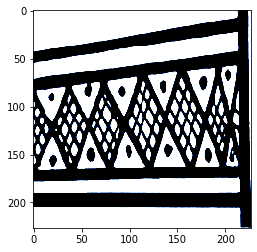

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical cross-hatched dot lozenge chain 
Labels predichos:
panel vertical hatched small multiple outline lozenge chain row tongue 


Mostrando imagen 1 del batch 1


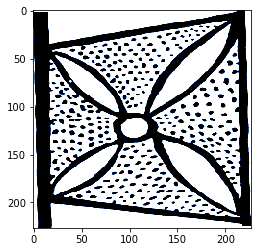

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal dotted quatrefoil reserved background 
Labels predichos:
andrew's cross chevron metopal hatched dotted cross-hatched latticed quatrefoil reserved background octofoil 


Mostrando imagen 2 del batch 1


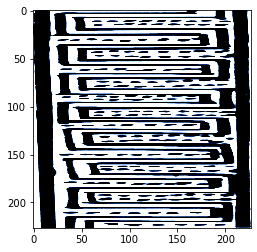

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel dot battlement 
Labels predichos:
horizontal panel hatched double hook dotted lozenge battlement chain 


Mostrando imagen 3 del batch 1


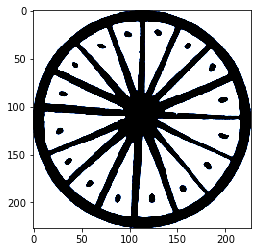

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing line ornament star dot circle floor 
Labels predichos:
enclosing ornament star circle octofoil swastika floor 


Mostrando imagen 4 del batch 1


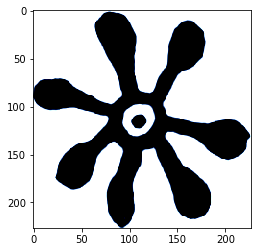

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament solid rosette 
Labels predichos:
line filling ornament single square star swastika 


Mostrando imagen 5 del batch 1


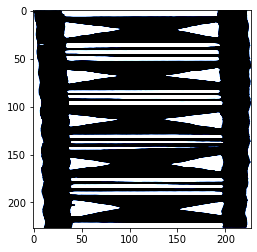

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel vertical bar solid double ax 
Labels predichos:
horizontal panel vertical bar filling ornament triangle solid dogtooth 


Mostrando imagen 6 del batch 1


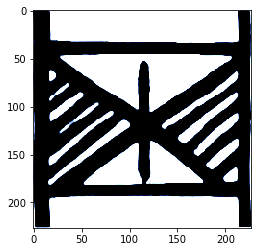

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal hatched hour-glass 
Labels predichos:
vertical andrew's chevron metopal stacked solid double dotted outline 


Mostrando imagen 7 del batch 1


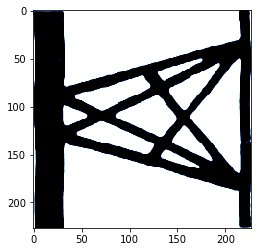

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal triangle 
Labels predichos:
enclosing filling ornament andrew's cross triangle double cross-hatched shoulder lozenge 


Mostrando imagen 8 del batch 1


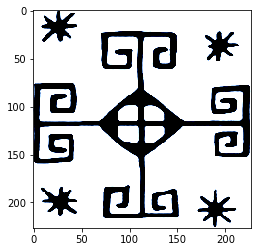

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
hook rectilinear 
Labels predichos:
hook rectilinear tree figure volute 


Mostrando imagen 9 del batch 1


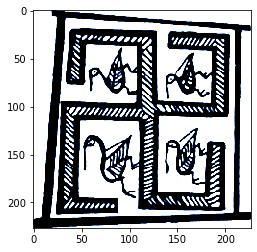

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal right hatched turning swastika 
Labels predichos:
metopal right left hatched dotted turning meander swastika 


Mostrando imagen 10 del batch 1


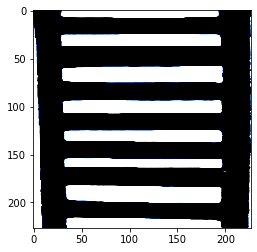

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel vertical bar 
Labels predichos:
horizontal panel vertical bar ornament dogtooth 


Mostrando imagen 11 del batch 1


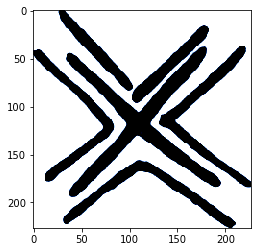

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
andrew's cross 
Labels predichos:
filling ornament andrew's cross metopal hatched double dotted quatrefoil 


Mostrando imagen 12 del batch 1


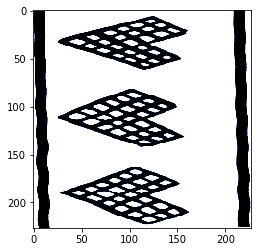

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel floating chevron cross-hatched 
Labels predichos:
horizontal panel hatched double zigzag bird 


Mostrando imagen 13 del batch 1


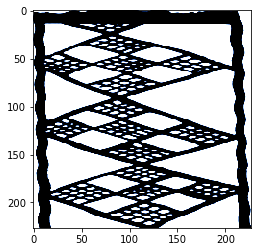

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel diagonal cross-hatched checkerboard chain 
Labels predichos:
horizontal panel hatched triangle double triple multiple parallel cross-hatched dot outline lozenge chain zigzag 


Mostrando imagen 14 del batch 1


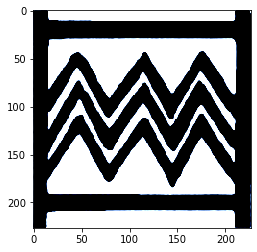

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical triple parallel zigzag 
Labels predichos:
panel vertical triangle double triple dotted dot outline quartered lozenge chain 


Mostrando imagen 15 del batch 1


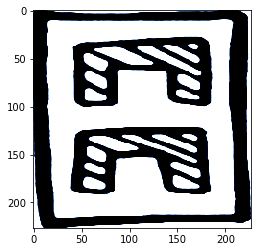

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel hook 
Labels predichos:
horizontal panel metopal hatched single hook meander swastika tree 


Mostrando imagen 16 del batch 1


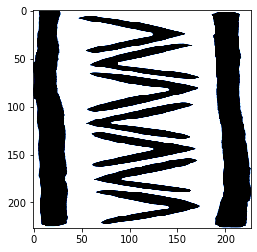

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel line chevron single zigzag 
Labels predichos:
horizontal panel floating band dot row tangential blob sigma flanking 


Mostrando imagen 17 del batch 1


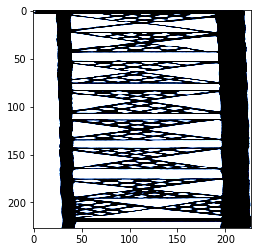

Labels correctos:
horizontal panel double cross-hatched ax 
Labels predichos:
horizontal panel bar hatched triangle apex double cross-hatched lozenge gear-pattern chain row 


Mostrando imagen 18 del batch 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


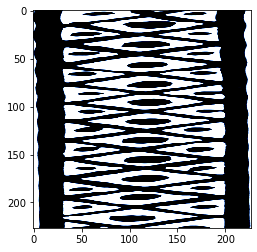

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel dot lozenge chain 
Labels predichos:
horizontal panel hatched triangle double cross-hatched wolftooth hatching outline lozenge chain row 


Mostrando imagen 19 del batch 1


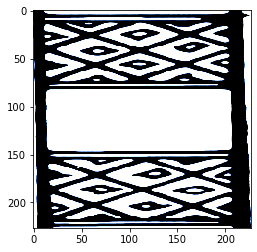

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
double lozenge net 
Labels predichos:
horizontal panel group vertical double multiple parallel outline zigzag scribble 


Mostrando imagen 20 del batch 1


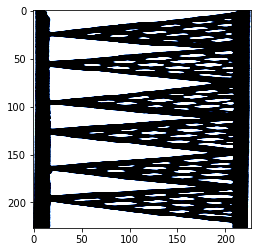

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel triangle cross-hatched 
Labels predichos:
horizontal panel vertical bar alternating simple andrew's cross hatched triangle double cross-hatched hatching outline zigzag ax 


Mostrando imagen 21 del batch 1


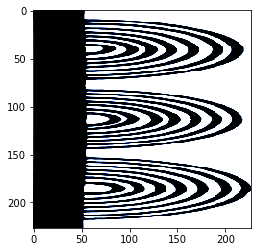

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
pendent horizontal panel concentric semicircle 
Labels predichos:
horizontal panel vertical bar battlement 


Mostrando imagen 22 del batch 1


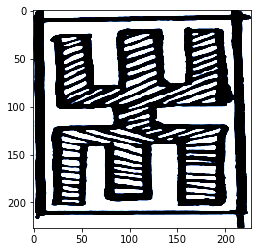

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel hatched double 
Labels predichos:
horizontal panel hatched double hook rectilinear meander 


Mostrando imagen 23 del batch 1


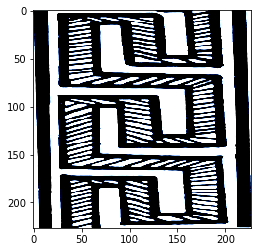

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel left hatched turning meander 
Labels predichos:
horizontal panel alternating pattern hatched double hook battlement turning meander 


Mostrando imagen 24 del batch 1


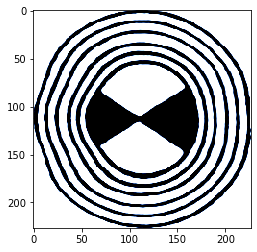

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing solid concentric hour-glass circle 
Labels predichos:
enclosing cross concentric george's hour-glass circle reserved 


Mostrando imagen 25 del batch 1


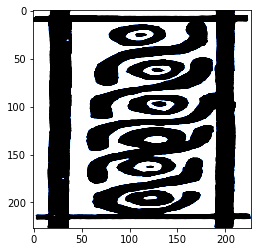

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel band circle 
Labels predichos:
horizontal panel double dot circle tangential 


Mostrando imagen 26 del batch 1


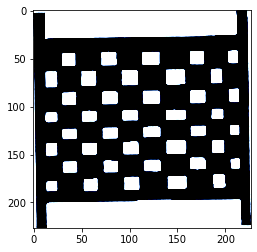

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical checkerboard 
Labels predichos:
vertical filling pattern metopal solid multiple square cross-hatched 


Mostrando imagen 27 del batch 1


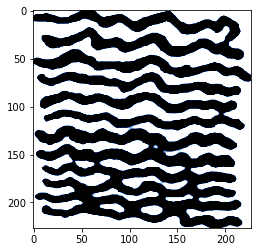

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical scribble 
Labels predichos:
horizontal panel vertical filling band net scribble 


Mostrando imagen 28 del batch 1


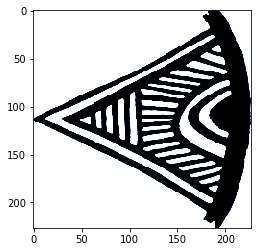

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
ornament composition triangle shoulder 
Labels predichos:
enclosing ornament triangle triple hour-glass shoulder outline 


Mostrando imagen 29 del batch 1


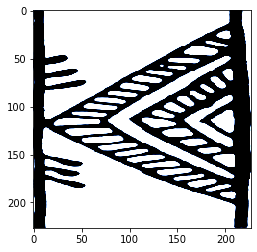

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel hatched triangle triple outline 
Labels predichos:
enclosing ornament andrew's cross triangle triple cross-hatched shoulder outline lozenge 


Mostrando imagen 30 del batch 1


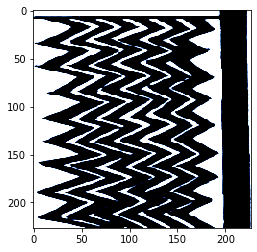

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel double triple multiple parallel zigzag 
Labels predichos:
horizontal panel vertical wavy band double triple multiple parallel lozenge net zigzag 


Mostrando imagen 31 del batch 1


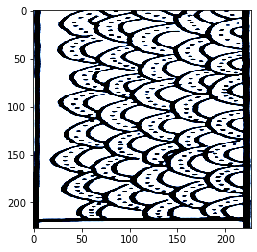

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel pattern double dotted 
Labels predichos:
horizontal panel vertical hatched wavy band multiple net zigzag scribble 


Mostrando imagen 32 del batch 1


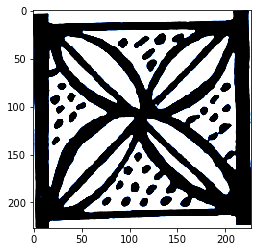

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal dotted quatrefoil reserved background 
Labels predichos:
andrew's cross chevron metopal hatched stacked double dotted latticed quatrefoil 


Mostrando imagen 33 del batch 1


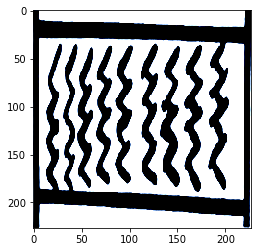

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical floating stacked multiple scribble 
Labels predichos:
panel vertical metopal solid double dot lozenge chain sigma scribble body bird 


Mostrando imagen 34 del batch 1


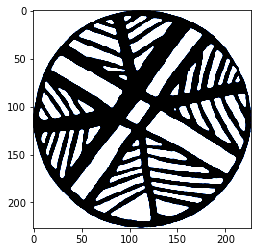

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing ornament cross pattern circle floor 
Labels predichos:
enclosing ornament cross-hatched circle reserved background octofoil floor 


Mostrando imagen 35 del batch 1


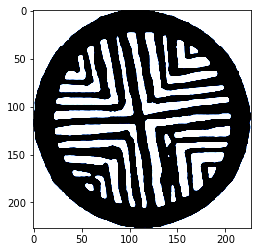

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
line ornament cross chevron circle floor 
Labels predichos:
enclosing ornament cross chevron dotted circle floor 


Mostrando imagen 36 del batch 1


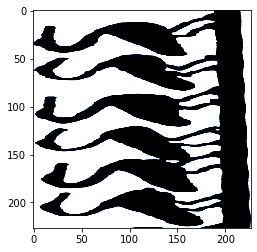

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel solid body bird 
Labels predichos:
horizontal panel filling ornament multiple lozenge scribble 


Mostrando imagen 37 del batch 1


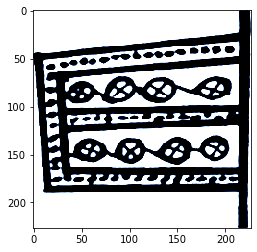

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament 
Labels predichos:
panel vertical hook scribble 


Mostrando imagen 38 del batch 1


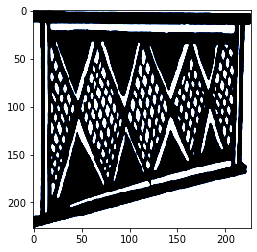

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical triangle field solid cross-hatched lozenge chain 
Labels predichos:
panel vertical filling ornament triangle solid cross-hatched outline lozenge 


Mostrando imagen 39 del batch 1


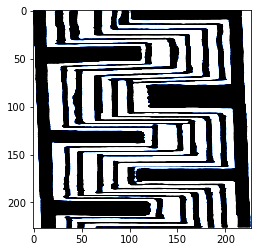

Labels correctos:
horizontal panel multiple outline battlement 
Labels predichos:
horizontal panel metopal right hatched single hook turning meander 


CURRENT BATCH SIZE:  124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mostrando imagen 0 del batch 2


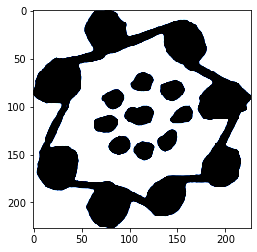

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
dot circle tangential blob rosette 
Labels predichos:
filling ornament dotted star dot rosette 


Mostrando imagen 1 del batch 2


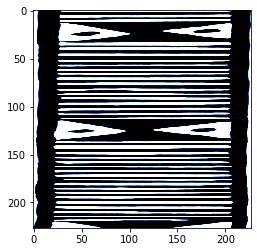

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel vertical bar filling ornament 
Labels predichos:
horizontal panel vertical bar line filling ornament 


Mostrando imagen 2 del batch 2


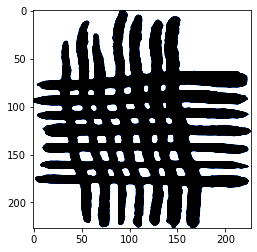

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
group bar filling ornament 
Labels predichos:
vertical filling ornament hatched cross-hatching dotted checkerboard floor 


Mostrando imagen 3 del batch 2


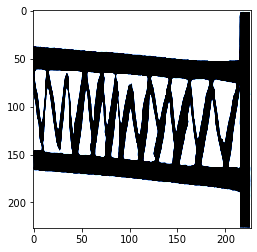

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical line single zigzag 
Labels predichos:
panel vertical bar right left gear-pattern 


Mostrando imagen 4 del batch 2


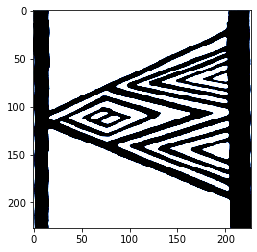

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing ornament triangle shoulder lozenge 
Labels predichos:
enclosing ornament triangle cross-hatching double triple cross-hatched hatching shoulder outline lozenge 


Mostrando imagen 5 del batch 2


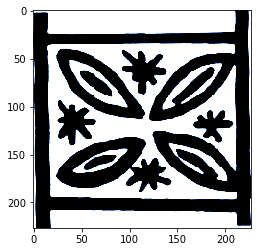

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
line simple metopal double single quatrefoil outline 
Labels predichos:
line simple metopal hatched double single quatrefoil tree 


Mostrando imagen 6 del batch 2


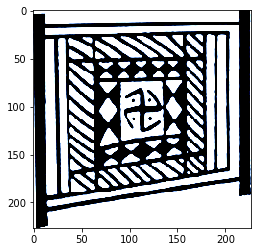

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
ornament rectangle 
Labels predichos:
panel vertical ornament stacked rectangle checkerboard background palm-tree 


Mostrando imagen 7 del batch 2


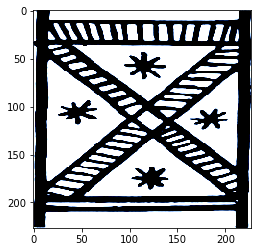

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
andrew's cross metopal hatched 
Labels predichos:
andrew's cross metopal hatched dotted cross-hatched quatrefoil bird 


Mostrando imagen 8 del batch 2


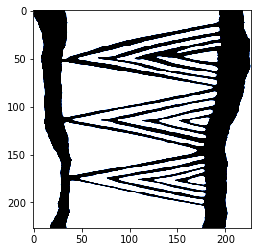

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel triangle concentric standing 
Labels predichos:
pendent horizontal panel hatched triangle double cross-hatched outline zigzag ax 


Mostrando imagen 9 del batch 2


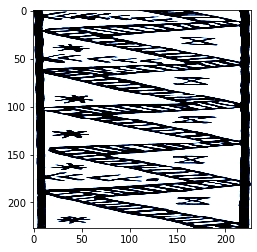

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel hatched zigzag 
Labels predichos:
horizontal panel hatched triangle double triple dotted cross-hatched dot outline lozenge chain leaf zigzag 


Mostrando imagen 10 del batch 2


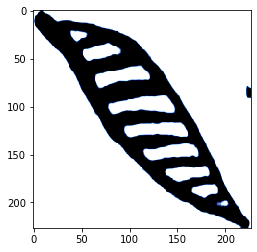

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament chevron hatching leaf 
Labels predichos:
horizontal panel filling ornament hatched solid double axe body bird 


Mostrando imagen 11 del batch 2


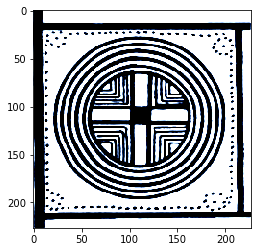

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing cross chevron concentric circle reserved 
Labels predichos:
enclosing simple cross metopal hatched concentric george's quarter circle reserved 


Mostrando imagen 12 del batch 2


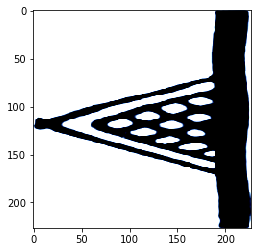

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament triangle double cross-hatched outline 
Labels predichos:
pendent enclosing ornament triangle double cross-hatched shoulder 


Mostrando imagen 13 del batch 2


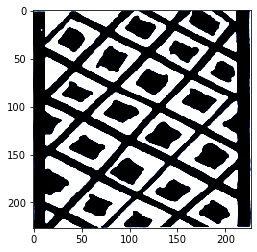

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing metopal solid lozenge net 
Labels predichos:
horizontal panel filling ornament cross band dotted circle lozenge scribble 


Mostrando imagen 14 del batch 2


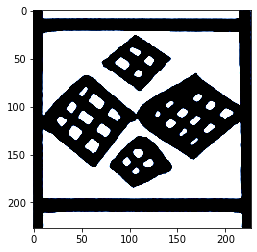

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
cross-hatched metope lozenge 
Labels predichos:
cross metopal dotted cross-hatched quartered lozenge volute 


Mostrando imagen 15 del batch 2


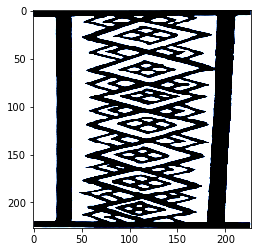

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel chevron double centre quartered lozenge chain 
Labels predichos:
horizontal panel double multiple dotted dot lozenge chain net tangential blob flanking 


Mostrando imagen 16 del batch 2


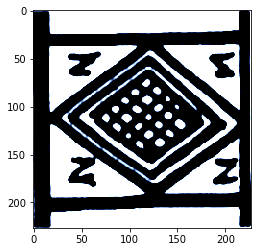

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal triple cross-hatched centre outline lozenge 
Labels predichos:
enclosing cross metopal hatched double checkerboard hatching dot outline lozenge 


Mostrando imagen 17 del batch 2


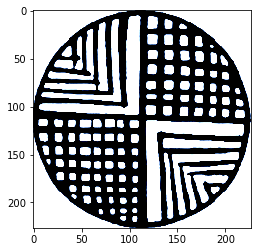

Labels correctos:
enclosing ornament chevron cross-hatching circle floor 
Labels predichos:
ornament hatched cross-hatching dotted centre circle floor 


Mostrando imagen 18 del batch 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


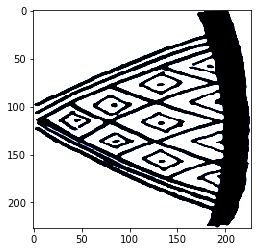

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
ornament triangle double shoulder dot outline lozenge 
Labels predichos:
enclosing filling ornament triangle double triple dotted cross-hatched hatching shoulder outline lozenge 


Mostrando imagen 19 del batch 2


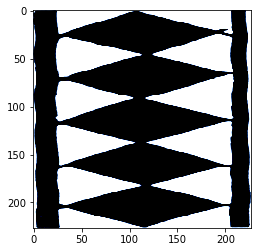

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel solid lozenge chain 
Labels predichos:
horizontal panel alternating metopal solid double dot accompanied antithetic ray ax 


Mostrando imagen 20 del batch 2


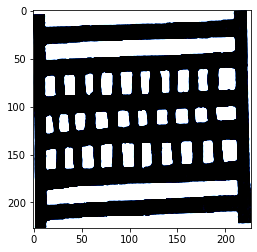

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical checkerboard 
Labels predichos:
panel vertical filling checkerboard chain 


Mostrando imagen 21 del batch 2


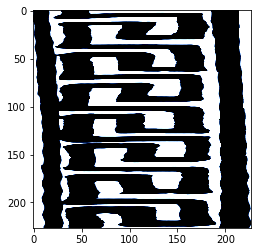

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel line left single turning meander 
Labels predichos:
horizontal panel line double single hook checkerboard link meander chain 


Mostrando imagen 22 del batch 2


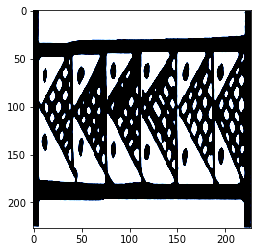

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical triangle cross-hatched 
Labels predichos:
panel vertical solid double triple multiple cross-hatched outline lozenge chain row 


Mostrando imagen 23 del batch 2


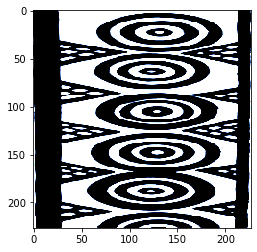

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel triangle concentric circle 
Labels predichos:
horizontal panel double triple concentric dotted dot circle lozenge tangential zigzag 


Mostrando imagen 24 del batch 2


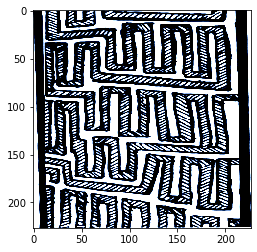

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel hatched multiple meander 
Labels predichos:
horizontal panel left hatched double triple turning meander chain inverted swastika 


Mostrando imagen 25 del batch 2


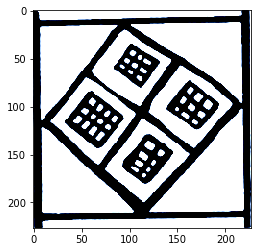

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing metopal cross-hatched quartered lozenge 
Labels predichos:
filling ornament metopal double dotted cross-hatched star outline quartered lozenge schematized 


Mostrando imagen 26 del batch 2


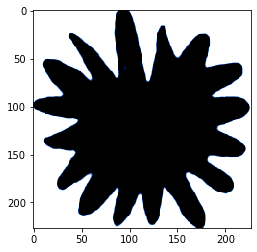

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament star 
Labels predichos:
filling ornament star swastika 


Mostrando imagen 27 del batch 2


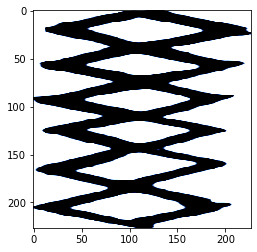

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal filling ornament lozenge chain 
Labels predichos:
filling ornament dotted lozenge chain inverted scribble 


Mostrando imagen 28 del batch 2


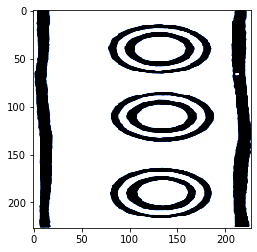

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel concentric circle 
Labels predichos:
horizontal panel concentric circle tangential 


Mostrando imagen 29 del batch 2


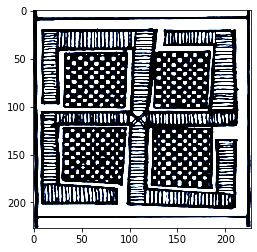

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal right hatched turning swastika 
Labels predichos:
ornament metopal rectangle cross-hatched checkerboard metope swastika 


Mostrando imagen 30 del batch 2


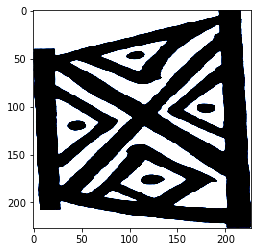

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
andrew's cross chevron stacked dotted latticed 
Labels predichos:
line filling andrew's cross chevron stacked double dotted latticed lozenge 


Mostrando imagen 31 del batch 2


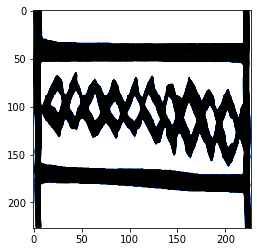

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical lozenge chain 
Labels predichos:
panel vertical right dotted dot lozenge chain 


Mostrando imagen 32 del batch 2


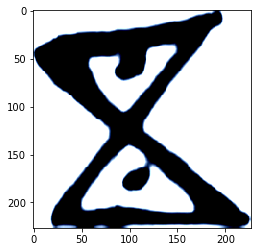

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
filling ornament double axe 
Labels predichos:
line filling ornament double single square shoulder dot swastika axe 


Mostrando imagen 33 del batch 2


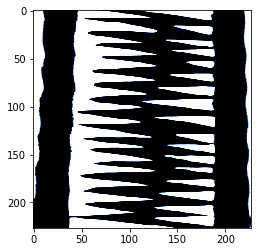

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel line single zigzag 
Labels predichos:
horizontal panel dot 


Mostrando imagen 34 del batch 2


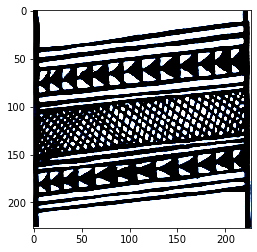

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
panel vertical triangle stacked solid 
Labels predichos:
panel vertical triangle checkerboard outline gear-pattern tongue 


Mostrando imagen 35 del batch 2


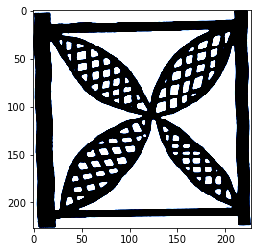

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
metopal cross-hatched quatrefoil 
Labels predichos:
metopal hatched double cross-hatched hour-glass quatrefoil outline wing body bird 


Mostrando imagen 36 del batch 2


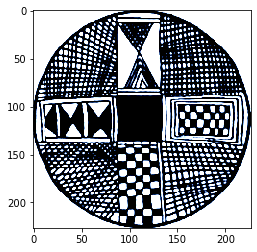

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
ornament cross pattern floor 
Labels predichos:
enclosing ornament cross solid cross-hatching cross-hatched circle background floor wing 


Mostrando imagen 37 del batch 2


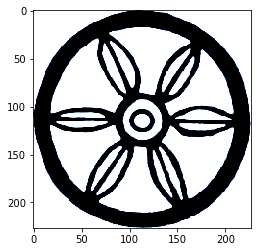

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
enclosing circle 
Labels predichos:
enclosing ornament star quatrefoil circle octofoil swastika leaf rosette floor 


Mostrando imagen 38 del batch 2


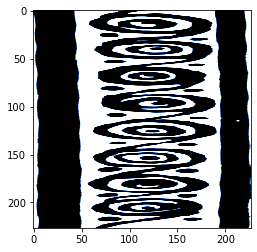

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels correctos:
horizontal panel double dot circle tangential 
Labels predichos:
horizontal panel double dotted dot circle lozenge tangential blob flanking 


Mostrando imagen 39 del batch 2


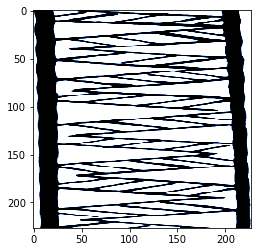

Labels correctos:
horizontal panel hatched apex zigzag 
Labels predichos:
horizontal panel line hatched triangle double cross-hatched wolftooth hatching outline lozenge row zigzag ax 


Test Trial [1/1], LR: 0.0001, W: 0.001, Avg Loss: 218.1179, Accuracy: 0.9360, F1 score: 0.4920, F2 score: 0.6006


NameError: name 'test' is not defined

In [41]:
# Instanciamos un pruner con la cantidad de etiquetas en estudio
pruner = KunischPruner(NUM_LABELS)

# Inicializamos sumas de scores en 0, para cada score de interés
sum_f1 = 0
sum_f2 = 0
sum_recall = 0
sum_precision = 0
sum_acc = 0
sum_hl = 0
sum_emr = 0
sum_hs = 0
sum_mr1 = 0
sum_mr2 = 0
sum_mr3 = 0
sum_mr4 = 0
sum_mr5 = 0

# Iterar sobre los folds, entrenando desde 0 (sin data leakage) y reportando
# los resultados en las variables anteriores (sum_...)
for i in range(0, K):
    fold = Kfolds[i]
    labels_dir = fold['labels_dir']
    patterns_dir = fold['patterns_dir']
    output_dir = fold['output_dir']
    model_path = fold['model_path']
    
    # Carga de top labels
    train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
    
    if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
        print(f"Creando top_labels para {NUM_LABELS} labels")
        top_labels = pruner.filter_labels(train_labels)
        pruner.set_top_labels(top_labels)
        
        save = input(f"Se creará un archivo nuevo para {len(top_labels)} labels. Desea continuar? (y/n)")
        if save == "y":
            with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
                pickle.dump(top_labels, f)
            print("Top labels creado con éxito")
            
        else:
            raise Exception("No se logró cargar top_labels")
            
    else: 
        print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
            top_labels = pickle.load(f)

    NUM_LABELS = len(top_labels) # la cantidad final de etiquetas a trabajar

    # Alexnet requires 227 x 227
    # Training
    kunischTrainSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'train'),
                                     labels_file=os.path.join(labels_dir, 'augmented_train_df.json'),
                                     transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize(
                                                                       mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])]),
                                     top_labels=top_labels)

    kunischTrainLoader = torch.utils.data.DataLoader(kunischTrainSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    # Validation
    kunischValidationSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'val'),
                                          labels_file=os.path.join(labels_dir, 'val_df.json'),
                                          transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize(
                                                                            mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225])]),
                                          top_labels=top_labels)

    kunischValidationLoader = torch.utils.data.DataLoader(kunischValidationSet, batch_size=BATCH_SIZE, shuffle=True,
                                                          num_workers=0)

    # Test
    kunischTestSet = KunischDataset(images_dir=os.path.join(patterns_dir, 'test'),
                                    labels_file=os.path.join(labels_dir, 'test_df.json'),
                                    transform=transforms.Compose([transforms.Resize((227, 227)),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize(
                                                                      mean=[0.485, 0.456, 0.406],
                                                                      std=[0.229, 0.224, 0.225])]),
                                    top_labels=top_labels)

    kunischTestLoader = torch.utils.data.DataLoader(kunischTestSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Creacion de pesos positivos
    if use_pos_weights:
        pos_weights = make_positive_weights(top_labels, len(kunischTrainSet), pos_weights_factor)
        pos_weights = torch.Tensor(pos_weights).float().to(device)

    else:
        pos_weights = None
        
    hyperval = """
    # Hyper Parameter Tuning
    alex_net = models.alexnet(pretrained=True)
    for param in alex_net.parameters():
        param.requires_grad = False
    alex_net.classifier._modules['6'] = nn.Linear(4096, NUM_LABELS)

    train_losses = []
    validation_losses = []
    num_epochs = 5

    for epoch in range(num_epochs):
      learning_rate = round(np.exp(random.uniform(np.log(.0001), np.log(.01))), 4)  # pull geometrically
      w = round(np.exp(random.uniform(np.log(3.1e-7), np.log(3.1e-5))), 10)  # pull geometrically

      # Reset Model per test
      alex_net = models.alexnet(pretrained=True)
      alex_net.classifier._modules['6'] = nn.Linear(4096, NUM_LABELS)
      alex_net.to(device)

      optimizer = torch.optim.Adam(alex_net.parameters(), lr=learning_rate, weight_decay=w)
      criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=5, min_lr=0.00005)

      alex_train(epoch, num_epochs, train_losses, learning_rate, w)
      if SAVE:
          train_losses_df = pd.DataFrame(train_losses)
          train_losses_df.to_csv(os.path.join(output_dir, 'loss_hypertrain.csv'))

      alex_valid(epoch, num_epochs, validation_losses, learning_rate, w)
      if SAVE:
          validation_losses_df = pd.DataFrame(validation_losses)
          validation_losses_df.to_csv(os.path.join(output_dir, 'loss_hyperval.csv'))
     """

    # Training
    train_losses = []
    validation_losses = []
    num_epochs = 200
    learning_rate = 0.001
    w = 0.01

    # Early Stopping
    patience = 10
    bad_epochs = 0
    best_score = 0.0
    best_weights = None

    alex_net = models.alexnet(pretrained=True)
    alex_net.classifier._modules['6'] = nn.Linear(4096, NUM_LABELS)
    alex_net.to(device)

    optimizer = torch.optim.Adam(alex_net.parameters(), lr=learning_rate, weight_decay=w)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=5, min_lr=0.0001)
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
      score_train = alex_train(epoch, num_epochs, train_losses, learning_rate, w)
      score_valid = alex_valid(epoch, num_epochs, validation_losses, learning_rate, w)
      print("")

      # Early Stopping
      if score_valid > best_score:
        bad_epochs = 0
        best_epoch = epoch
        best_score = score_valid
        best_weights = alex_net.state_dict()
      else:
        bad_epochs += 1

      if bad_epochs == patience:
        print("Out of patience!")
        print(f"Best epoch: {best_epoch}")
        break

    if SAVE:
        print(f"Guardando mejor modelo en {model_path}")
        torch.save(best_weights, model_path)


    # Testing
    test_losses = []
    test_pred = []
    learning_rate = 0.0001
    w = 0.001

    # Reset Model
    alex_net = models.alexnet(pretrained=True)
    alex_net.classifier._modules['6'] = nn.Linear(4096, NUM_LABELS)
    alex_net.load_state_dict(torch.load(model_path))
    alex_net.to(device)

    optimizer = torch.optim.Adam(alex_net.parameters(), lr=learning_rate, weight_decay=w)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    alex_test(1, 1, test_pred, test_losses, learning_rate, w, show_images = 40)
    test_pred_df = pd.DataFrame(test_pred)
    
    # Guardar resultados si corresponde
    preds = test_pred[0][3].cpu().detach().numpy()
    for i in range(1, len(test_pred)):
      pbi = test_pred[i][3].cpu().detach().numpy()
      preds = np.concatenate((preds, pbi), axis=0)
        
    if SAVE:
        save_df = pd.DataFrame(preds)
        save_df.to_csv(os.path.join(output_dir, 'predictions.csv'))
        print(f"Predicciones guardadas en {os.path.join(output_dir, 'predictions.csv')}")
        preds = pd.read_csv(os.path.join(output_dir, 'predictions.csv'), index_col=0)
        preds = preds.values

    pruner = KunischPruner(preds.shape[1])
    pruner.set_top_labels(top_labels)
    test = pruner.filter_df(labels_test)
    
    metrics = KunischMetrics(test.values, preds)
    sum_f1 += metrics.f1()
    sum_f2 += metrics.f2()
    sum_recall += metrics.recall()
    sum_precision += metrics.precision()
    sum_acc += metrics.acc()
    sum_hl += metrics.hl()
    sum_emr += metrics.emr()
    sum_hs += metrics.hs()
    sum_mr1 += metrics.mr1()
    sum_mr2 += metrics.mr2()
    sum_mr3 += metrics.mr3()
    sum_mr4 += metrics.mr4()
    sum_mr5 += metrics.mr5()

    print(f"HS fold {i}: {metrics.hs()}")

# Los scores finales como el promedio de los scores individuales
avg_f1 = round(sum_f1/K, 4)
avg_f2 = round(sum_f2/K, 4)
avg_recall = round(sum_recall/K, 4)
avg_precision = round(sum_precision/K, 4)
avg_acc = round(sum_acc/K, 4)
avg_hl = round(sum_hl/K, 4)
avg_emr = round(sum_emr/K, 4)
avg_hs = round(sum_hs/K, 4)
avg_mr1 = round(sum_mr1/K, 4)
avg_mr2 = round(sum_mr2/K, 4)
avg_mr3 = round(sum_mr3/K, 4)
avg_mr4 = round(sum_mr4/K, 4)
avg_mr5 = round(sum_mr5/K, 4)

# Generar un archivo de metadatos 
metadata = {
'data_flags': data_flags,
'use_pos_weights': use_pos_weights,
'pos_weights_factor': pos_weights_factor,
'patience': patience,
'batch_size': BATCH_SIZE,
'optimizer': (type (optimizer).__name__),
'scheduler': (type (scheduler).__name__),
'criterion': (type (criterion).__name__),
'epochs': num_epochs,
'best_epoch': best_epoch,
'num_labels': NUM_LABELS,
'TH_TRAIN': TH_TRAIN,
'TH_VAL': TH_VAL,
'TH_TEST': TH_TEST,
'f1': avg_f1,
'f2': avg_f2,
'recall': avg_recall,
'precision': avg_precision,
'acc': avg_acc,
'hl': avg_hl,
'emr': avg_emr,
'hs': avg_hs,
'mr1': avg_mr1,
'mr2': avg_mr2,
'mr3': avg_mr3,
'mr4': avg_mr4,
'mr5': avg_mr5
}

# Reportar resultados interesantes por print
print("HS Final: ", avg_hs)
print("F1 Final: ", avg_f1)
print("F2 Final: ", avg_f2)
print("1MR Final: ", avg_mr1)
print("5MR Final: ", avg_mr5)

# Guardar metadatos si corresponde
if SAVE:
    metadf = pd.DataFrame.from_dict(metadata, orient='index')
    # output_dir pero sin numero de fold
    metadf.to_csv(os.path.join(root_dir, "outputs", "alexnet", data_flags, exp_name, 'metadata.csv'))